In [4]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = open('names.txt','r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [6]:
len(words)

32033

In [7]:
#Build the Vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = { i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [8]:
#Build Dataset
from typing import List, Optional, Tuple

block_size = 3

def build_dataset(words:Optional[List]) -> Tuple:
    
    assert isinstance(words, list) , 'Give a valid input'
    
    X,Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 *len(words))
n2 = int(0.9 * len(words))  
Xtr, Ytr = build_dataset(words=words[:n1])
Xdev, Ydev = build_dataset(words=words[n1:n2])
Xte, Yte = build_dataset(words=words[n2:])

print(f"Train dataset Xtr {Xtr.shape}, Ytr {Ytr.shape}")
print(f"Val dataset Xdev {Xdev.shape}, Ydev {Ydev.shape}")
print(f"Test dataset Xte {Xte.shape}, Yte {Yte.shape}")   
    

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])
Train dataset Xtr torch.Size([182625, 3]), Ytr torch.Size([182625])
Val dataset Xdev torch.Size([22655, 3]), Ydev torch.Size([22655])
Test dataset Xte torch.Size([22866, 3]), Yte torch.Size([22866])


In [28]:
#MLP Revisited

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator= g)
W1 = torch.randn((block_size * n_embd , n_hidden), generator= g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator= g) * 0.01
b2 = torch.randn(vocab_size , generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [29]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb] #embed the chartacters into vectors
    embcat = emb.view(emb.shape[0], -1) #now concatenate the vectors
    hpreact = embcat @ W1 +b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #Output layers
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    #update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    #track_stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3221


In [51]:
h

tensor([[-1.0000,  0.9966, -1.0000,  ..., -0.9867,  0.6687,  0.9998],
        [-1.0000,  0.7579, -0.4107,  ...,  0.5295,  1.0000,  1.0000],
        [-0.9980, -0.8511, -0.9607,  ..., -1.0000,  1.0000,  0.9999],
        ...,
        [-0.9998, -0.8664, -1.0000,  ...,  0.9978, -1.0000, -0.9999],
        [-1.0000,  0.7579, -0.4107,  ...,  0.5295,  1.0000,  1.0000],
        [-1.0000, -0.9884, -1.0000,  ...,  0.9812,  0.9581,  1.0000]],
       grad_fn=<TanhBackward0>)

In [42]:
# We have more loss 27.8817 when we intantiated the weights and biases and the extreme values of logits will cause the loss to be very high

# 4 -dimensional example of the issue 
# `logits = torch.tensor([0.0,0.0,0.0,0.0])
# probs = torch.softmax(logits, dim = 0)
# loss = -probs[2].log()
# logits, probs, loss`

# `(tensor([0., 0., 0., 0.]),
#  tensor([0.2500, 0.2500, 0.2500, 0.2500]),
#  tensor(1.3863))`

#  the above example is when the logits are zero the prob is evely distributed

# the logit in the index 2 is changed and  we can notice the loss is less
# `logits = torch.tensor([0.0,0.0,5.0,0.0])
# probs = torch.softmax(logits, dim = 0)
# loss = -probs[2].log()
# logits, probs, loss`

# `(tensor([0., 0., 5., 0.]),
#  tensor([0.0066, 0.0066, 0.9802, 0.0066]),
#  tensor(0.0200))`

#  Now when the logits of other is index is given extreme values the loss is very high
# `logits = torch.tensor([10.0,0.0,5.0,0.0])
# probs = torch.softmax(logits, dim = 0)
# loss = -probs[2].log()
# logits, probs, loss`

# `(tensor([10.,  0.,  5.,  0.]),
#  tensor([9.9322e-01, 4.5092e-05, 6.6922e-03, 4.5092e-05]),
#  tensor(5.0068))`

In [43]:
#We can achieve less loss during the first iteration
#By making the weights and biases close to zero 
#we cannot make the weight to zero because they can permenantly damage the neurons in the network during back propagation

In [14]:
## the logits ranges from -1 to 1 because of tanh activation function
#it basically squashes the valuews between -1 to 1
#output of 
# h
# tensor([[-1.0000,  0.9966, -1.0000,  ..., -0.9867,  0.6687,  0.9998],
#         [-1.0000,  0.7579, -0.4107,  ...,  0.5295,  1.0000,  1.0000],
#         [-0.9980, -0.8511, -0.9607,  ..., -1.0000,  1.0000,  0.9999],
#         ...,
#         [-0.9998, -0.8664, -1.0000,  ...,  0.9978, -1.0000, -0.9999],
#         [-1.0000,  0.7579, -0.4107,  ...,  0.5295,  1.0000,  1.0000],
#         [-1.0000, -0.9884, -1.0000,  ...,  0.9812,  0.9581,  1.0000]],
#        grad_fn=<TanhBackward0>)

#from the below histogram we see that there are extreme values of -1 and 1 which arew not good for back propagation where
#these values will make the gradient 0 and potentially will make the neurons dead which in turn wont be useful for the other iterations
#because the neurons weights wont be updated

In [32]:
##if the entire colum  is white then it becomes dead neuron and they never learn
#white is the area where the logits are extreme values like -1 , -0.99 and 1 and 0.99

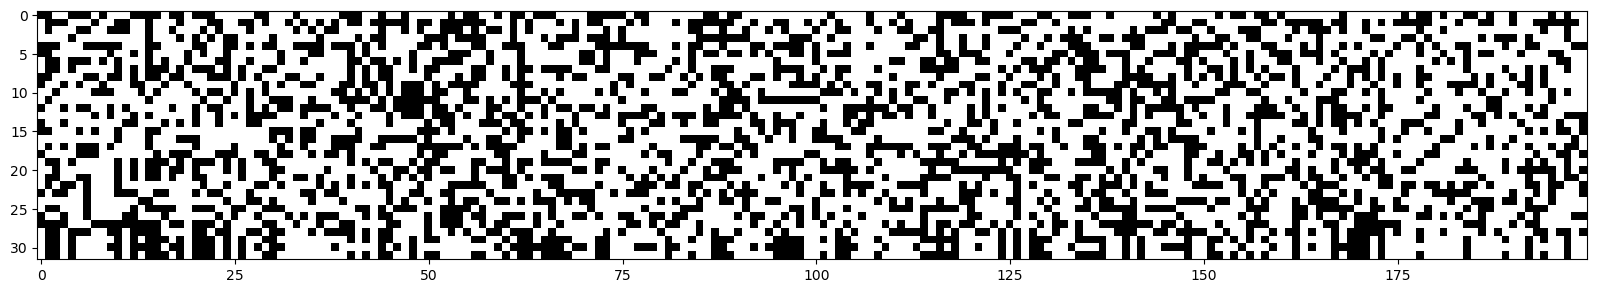

In [31]:
plt.figure(figsize= (20,10))
plt.imshow(h.abs() >  0.99, cmap = 'gray', interpolation = 'nearest')
#the h is the output when ran for the first iteration

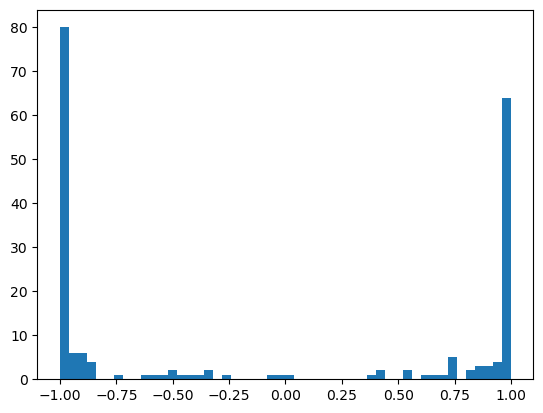

In [26]:
plt.hist(h.view(-1).tolist(), 50);

(array([80.,  6.,  6.,  4.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  2.,
         1.,  1.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  2.,
         0.,  1.,  1.,  1.,  5.,  0.,  2.,  3.,  3.,  4., 64.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

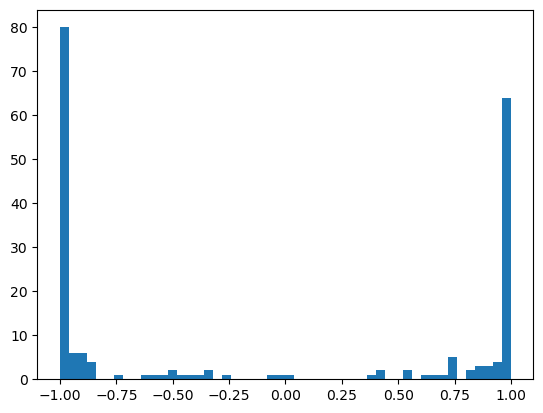

In [27]:
plt.hist(h.view(-1).tolist(), 50)

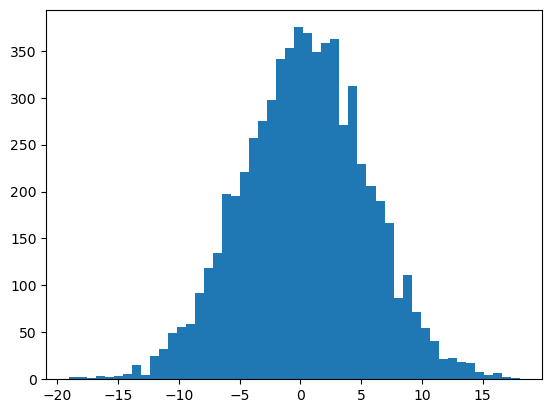

In [34]:
plt.hist(hpreact.view(-1).tolist(),50);

In [33]:
## relu , sigmoid, tanh will be affected from thjis issue
# Leaky Relu and ELU wont be affected much from this issue

In [40]:
# 4 -dimensional example of the issue 
logits = torch.tensor([10.0,0.0,5.0,0.0])
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
logits, probs, loss

(tensor([10.,  0.,  5.,  0.]),
 tensor([9.9322e-01, 4.5092e-05, 6.6922e-03, 4.5092e-05]),
 tensor(5.0068))

In [27]:
emb.shape, emb.view(32, -1).shape, emb.view(-1, 30).shape

(torch.Size([32, 3, 10]), torch.Size([32, 30]), torch.Size([32, 30]))

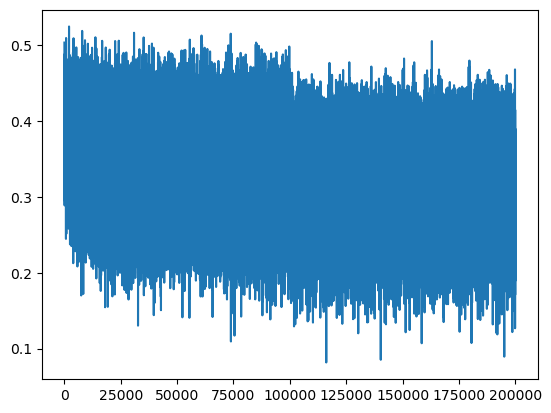

In [15]:
plt.plot(lossi)

In [16]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train' : (Xtr,Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]
    embcat = emb.view(x.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits =  h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')   

train 2.06957745552063
val 2.131200075149536


In [17]:
#sample the model
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:
        
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs =  F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs,
                               num_samples=1,
                               generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))
        

mora.
mayah.
seel.
ndyn.
alerethruthadrie.
cadelyn.
elin.
shi.
jen.
eden.
est.
aarvelyzion.
kamin.
shub.
roshimies.
kin.
renlynn.
novana.
ubeen.
der.


## Version 2 to tackle the above issue

In [43]:
#MLP Revisited

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator= g) 
W1 = torch.randn((block_size * n_embd , n_hidden), generator= g) * 0.2 
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator= g) * 0.01
b2 = torch.randn(vocab_size , generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [44]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb] #embed the chartacters into vectors
    embcat = emb.view(emb.shape[0], -1) #now concatenate the vectors
    hpreact = embcat @ W1 +b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #Output layers
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    #update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    #track_stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3135


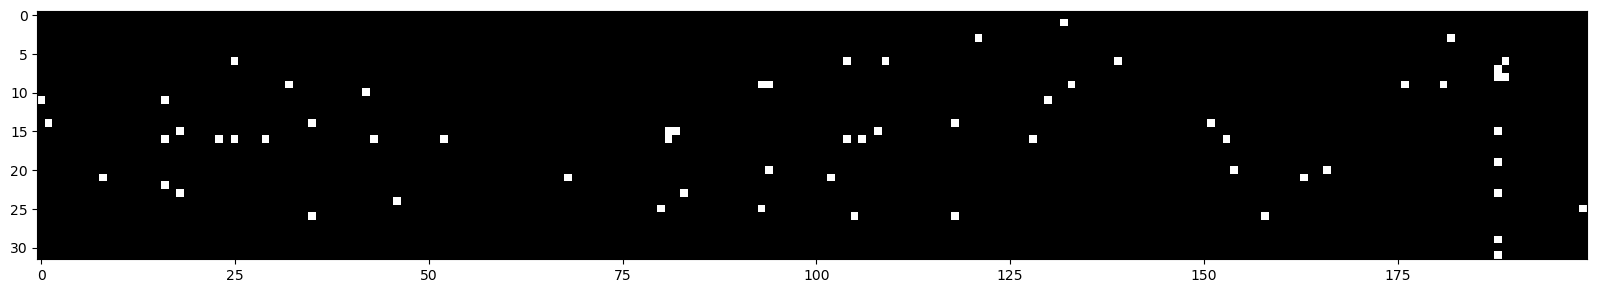

In [45]:
plt.figure(figsize= (20,10))
plt.imshow(h.abs() >  0.99, cmap = 'gray', interpolation = 'nearest')
#the h is the output when ran for the first iteration

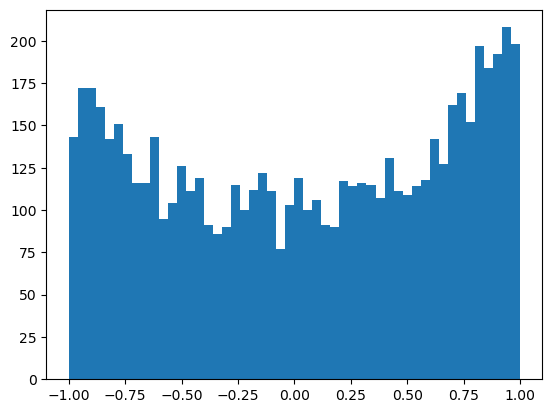

In [46]:
plt.hist(h.view(-1).tolist(), 50);

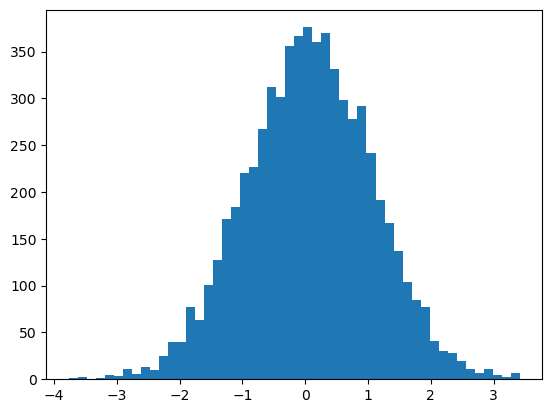

In [47]:
plt.hist(hpreact.view(-1).tolist(),50);

## Run with full sample

In [48]:
#MLP Revisited

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator= g) 
W1 = torch.randn((block_size * n_embd , n_hidden), generator= g) * 0.2 
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator= g) * 0.01
b2 = torch.randn(vocab_size , generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [49]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb] #embed the chartacters into vectors
    embcat = emb.view(emb.shape[0], -1) #now concatenate the vectors
    hpreact = embcat @ W1 +b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #Output layers
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    #update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    #track_stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
#     break

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


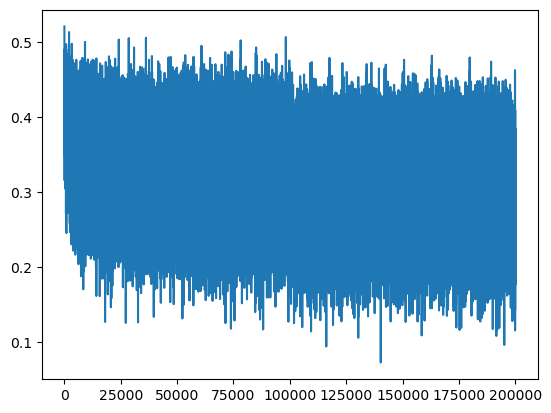

In [50]:
plt.plot(lossi)

In [51]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train' : (Xtr,Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]
    embcat = emb.view(x.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits =  h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')   

train 2.0355966091156006
val 2.102678060531616


In [52]:
#sample the model
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:
        
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs =  F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs,
                               num_samples=1,
                               generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))
        

mora.
mayah.
see.
mad.
ryll.
renvestendraegusteredielin.
shi.
jen.
edeiseananar.
kayzion.
kamin.
shubergianaiya.
kinde.
jennex.
teron.
ububynder.
yarue.
els.
kayshaykella.
hal.


In [53]:
# W1 = torch.randn((block_size * n_embd , n_hidden), generator= g) * 0.2 
# b1 = torch.randn(n_hidden, generator=g) * 0.01
# W2 = torch.randn((n_hidden, vocab_size), generator= g) * 0.01
# b2 = torch.randn(vocab_size , generator=g) * 0

#How to choose the numbers that we multiply with the weights and biases

#Notice that the standard deviation is more after the matrix multiplication for th gaussian inputs
#it is wise that the standard deviation should be the same even after the matrix ,multiplication


x_mean 0.0057, x_std 1.0001
Y_mean 0.0044, y_std 3.1951


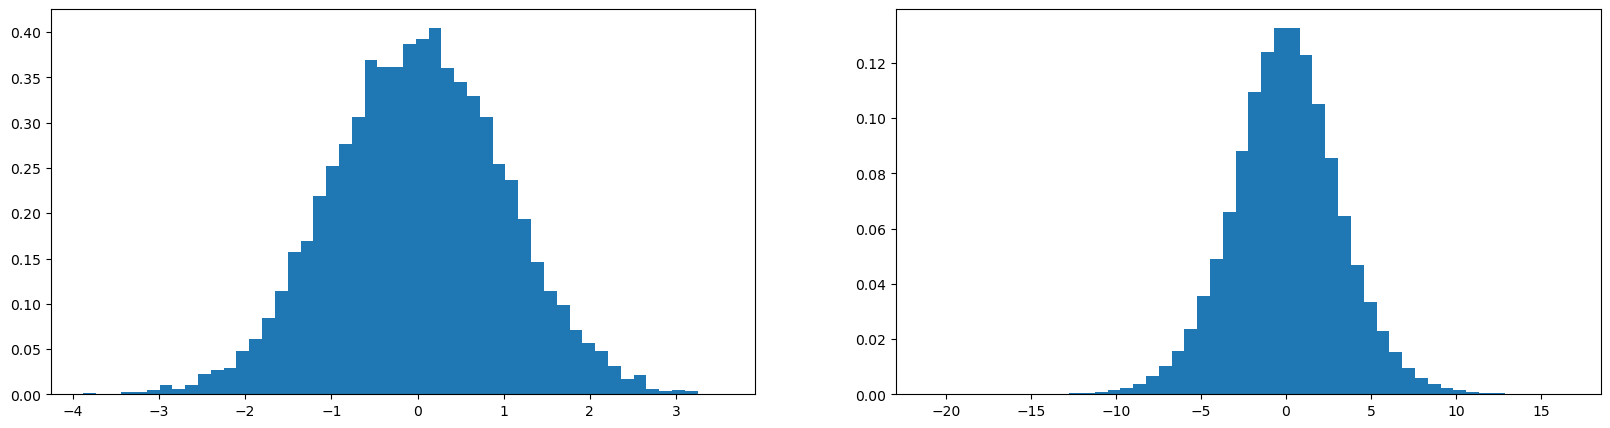

In [60]:
x = torch.randn(1000, 10)
w = torch.randn(10,200)
y = x @ w
print(f"x_mean {x.mean():.4f}, x_std {x.std():.4f}")
print(f'Y_mean {y.mean():.4f}, y_std {y.std():.4f}')
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

In [ ]:
# after multiplying the weights by 5 the standar deviation has been increased a lot for the output(matrix multiplication)

x_mean 0.0024, x_std 0.9927
Y_mean -0.0308, y_std 15.7457


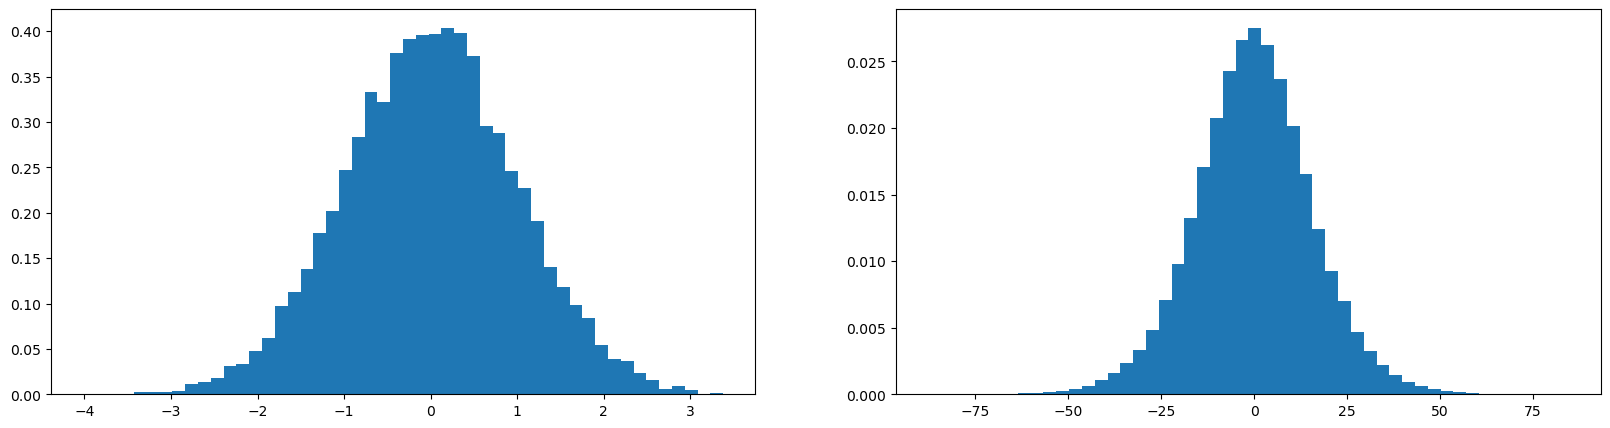

In [61]:
x = torch.randn(1000, 10)
w = torch.randn(10,200) * 5
y = x @ w
print(f"x_mean {x.mean():.4f}, x_std {x.std():.4f}")
print(f'Y_mean {y.mean():.4f}, y_std {y.std():.4f}')
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

x_mean 0.0176, x_std 1.0045
Y_mean 0.0000, y_std 1.1062


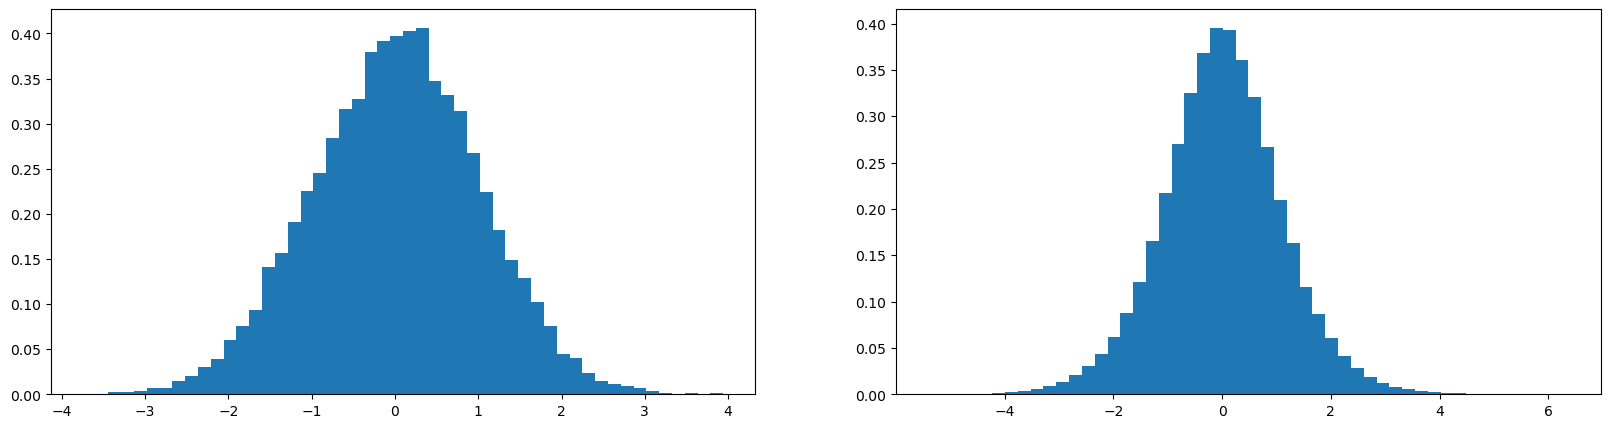

In [70]:
x = torch.randn(1000, 10)
w = torch.randn(10,200) * 0.34
y = x @ w
print(f"x_mean {x.mean():.4f}, x_std {x.std():.4f}")
print(f'Y_mean {y.mean():.4f}, y_std {y.std():.4f}')
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

In [ ]:
#Now the standard deviation is almost same for both the input adn the output

#the common formula to find the number thatr need to be multiplied is to divide by square root of the fan n of the input


x_mean -0.0012, x_std 1.0071
Y_mean 0.0006, y_std 0.9977


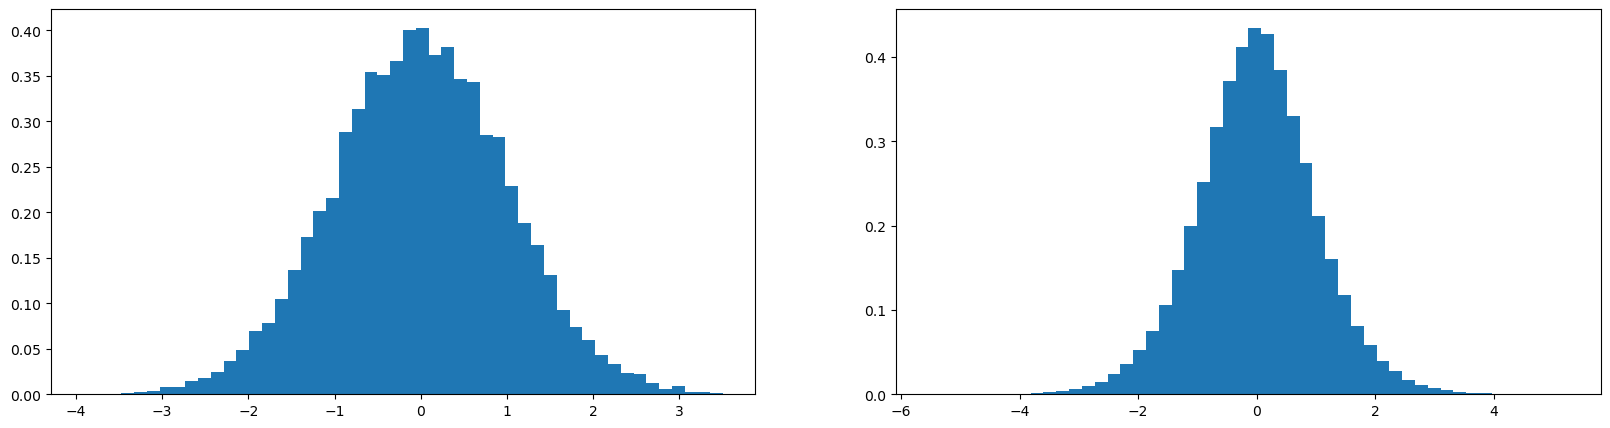

In [71]:
x = torch.randn(1000, 10)
w = torch.randn(10,200) / 10**0.5
y = x @ w
print(f"x_mean {x.mean():.4f}, x_std {x.std():.4f}")
print(f'Y_mean {y.mean():.4f}, y_std {y.std():.4f}')
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

In [73]:
#We do have kaiming init to get the absolute value(known as Gain) to initialize the weights and biases according to the activations

In [74]:
#for tanh we can calulate the constant number be 
(5/3) / ((block_size * n_embd)**0.5)

0.3042903097250923

In [75]:
#updating the initializing the weights
#but in the modern eep learning frame work this method is optomized and need not to worry about initializing the weights

# n_embd = 10
# n_hidden = 200

# g = torch.Generator().manual_seed(2147483647)
# C = torch.randn((vocab_size, n_embd), generator= g) 
# W1 = torch.randn((block_size * n_embd , n_hidden), generator= g) * (5/3) / ((block_size * n_embd)**0.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.01
# W2 = torch.randn((n_hidden, vocab_size), generator= g) * 0.01
# b2 = torch.randn(vocab_size , generator=g) * 0

# parameters = [C, W1, b1, W2, b2]
# print(sum(p.nelement() for p in parameters))
# for p in parameters:
#     p.requires_grad = True